# Processing

In this example, we discuss different ways to process an event in Python. We compare several approaches to find the most efficient one.

Processing large amounts of data in Python can be as fast as in C++ if one uses Numpy and Numba effectively, and if data structures of the underlying C++ library can be directly access as Numpy array views. Unfortunately, the internal design of the C++ HepMC3 library does not allow us to do that. Therefore, processing a GenEvent in Python cannot be as fast as in C++.

That being said, pyhepmc offers special methods that allow at least fast read-only access to the most important properties of particles and vertices via Numpy arrays. These Numpy arrays are not views, however, they are created from scratch and are filled internally with fast C++ loops. We will see that this still speeds up the processing of large events.

We demonstrate three methods to compute the energy sum in final state protons. We apply these methods on a comparably small event with 23 particles and a large event with 2661 particles.

In [1]:
import pyhepmc as hp
from particle import literals as lp
import numpy as np
from IPython.display import display

with hp.open("../../tests/sibyll21.dat") as f:
    for small_event in f:
        pass

with hp.open("../../tests/eposlhc_large.dat") as f:
    for large_event in f:
        pass

print("small event", len(small_event.particles), "particles")
print("large event", len(large_event.particles), "particles")

small event 23 particles
large event 2661 particles


**Method 1**

In our first method, we use the normal event API. We need to loop over particles, select those which are protons and final state (status == 1), and sum their energies.

In [2]:
def sum_energy_of_protons_1(event):
    esum = 0.0
    for p in event.particles:
        if abs(p.pid) != lp.proton.pdgid:
            continue
        if p.status != 1:
            continue
        esum += p.momentum.e
    return esum

sum_energy_of_protons_1(large_event)

8546.505081295967

**Method 2**

As already mentioned, the internal structure of the GenEvent cannot be viewed as Numpy arrays. However, HepMC3 supports an alternative in-memory representation, the GenEventData object. This object allows us to view its memory as a Numpy array. This can be used also to manipulate the internal state, as long as the number of particles is not changed.

We allocate one GenEventData object and write the data from the GenEvent into it. Then we use views in form of Numpy arrays into its memory to select and sum the particles of interest using fast Numpy functions.

In [3]:
event_data = hp.GenEventData()


def sum_energy_of_protons_2(event):
    event.write_data(event_data)
    p = event_data.particles
    ma = (np.abs(p["pid"]) == lp.proton.pdgid)
    ma &= p["status"] == 1
    e = p["e"]
    return np.sum(e[ma])


sum_energy_of_protons_2(large_event)

8546.505081295967

**Method 3**

The caveat of the previous method is that we have to convert the GenEvent into a GenEventData object, which is not cheap. Therefore, an additional interface was added to the GenEvent, which provides readonly access to important vertex and particles properties in form of Numpy arrays. These arrays are not views into the GenEvent object, and therefore cannot be used to manipulate the GenEvent.

In [4]:
def sum_energy_of_protons_3(event):
    ma = np.abs(event.np_particles_pdg_id()) == lp.proton.pdgid
    ma &= event.np_particles_status() == 1
    e = event.np_particles_momentum_e()
    return np.sum(e[ma])

sum_energy_of_protons_3(large_event)

8546.505081295967

Let's benchmark the methods and compare their speed.

In [5]:
t1a = %timeit -n 10 -o sum_energy_of_protons_1(small_event)
t1b = %timeit -n 10 -o sum_energy_of_protons_1(large_event)

t2a = %timeit -n 10 -o sum_energy_of_protons_2(small_event)
t2b = %timeit -n 10 -o sum_energy_of_protons_2(large_event)

t3a = %timeit -n 10 -o sum_energy_of_protons_3(small_event)
t3b = %timeit -n 10 -o sum_energy_of_protons_3(large_event)

14.7 µs ± 1.61 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.32 ms ± 65.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 4.37 times longer than the fastest. This could mean that an intermediate result is being cached.
26.3 µs ± 18.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
The slowest run took 4.61 times longer than the fastest. This could mean that an intermediate result is being cached.
428 µs ± 212 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.03 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
18 µs ± 720 ns per loop (mean ± std. dev. of 7 runs, 10 loops each)


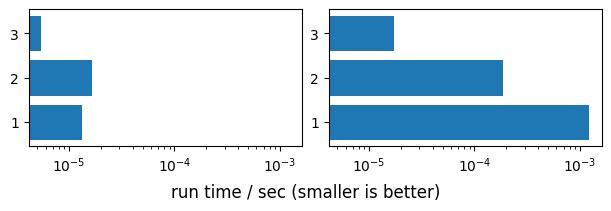

In [6]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(6, 2), sharex=True, constrained_layout=True)
ax[0].barh(["1", "2", "3"], [t.best for t in [t1a, t2a, t3a]])
ax[1].barh(["1", "2", "3"], [t.best for t in [t1b, t2b, t3b]])
fig.supxlabel("run time / sec (smaller is better)")
plt.semilogx();

In [7]:
t1a.best / t3a.best, t1b.best / t3b.best

(2.4325594721343187, 70.63575796056466)

Method 3 is the fastest method for read-only processing of events for both large and small events. In case of large (small) events, it is 70x (2x) faster.